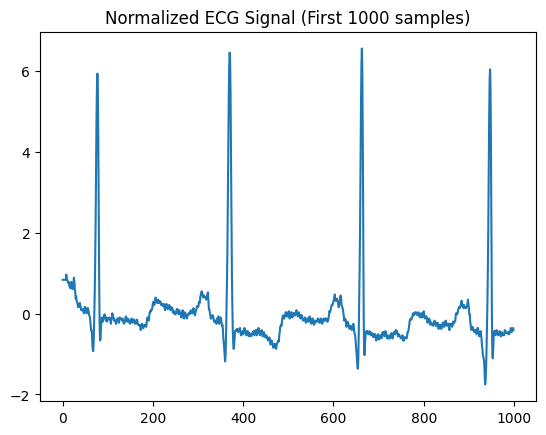

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/50], Train Loss: 0.8565, Val Loss: 0.8137
Epoch [20/50], Train Loss: 0.7350, Val Loss: 0.6795
Epoch [30/50], Train Loss: 0.3597, Val Loss: 0.3051
Epoch [40/50], Train Loss: 0.0893, Val Loss: 0.0424
Epoch [50/50], Train Loss: 0.0272, Val Loss: 0.0083
Background Model Epoch [10/50], Loss: 0.8473
Background Model Epoch [20/50], Loss: 0.6575
Background Model Epoch [30/50], Loss: 0.2791
Background Model Epoch [40/50], Loss: 0.0691
Background Model Epoch [50/50], Loss: 0.0252


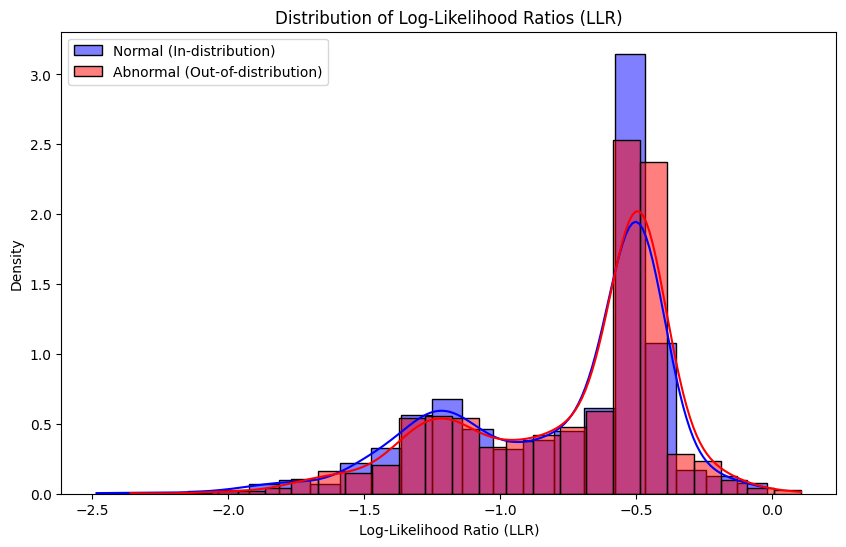

Confusion Matrix:
[[ 48128 114372]
 [ 46336 116164]]
Recall: 0.7149
F1 Score: 0.5911
Log-Likelihood (Normal): -0.02426134981215
Log-Likelihood (Background): -0.03730831295251846


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Load ECG data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Deep Learning/Project/100.csv')

# Drop unnecessary columns and extract ECG signal (MLII lead)
df = df.drop(['Unnamed: 0', 'time_ms'], axis=1)
ecg_signal = df['MLII'].values

# Normalize the ECG signal
ecg_signal = (ecg_signal - np.mean(ecg_signal)) / np.std(ecg_signal)

# Plot the ECG signal (First 1000 samples)
plt.plot(ecg_signal[:1000])
plt.title('Normalized ECG Signal (First 1000 samples)')
plt.show()

# Split data into training and test sets
train_data = ecg_signal[:len(ecg_signal)//2]
test_data = ecg_signal[len(ecg_signal)//2:]

# Further split train data into training and validation sets
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
train_data_tensor = torch.tensor(train_data, dtype=torch.float32).unsqueeze(0).unsqueeze(2)
val_data_tensor = torch.tensor(val_data, dtype=torch.float32).unsqueeze(0).unsqueeze(2)
test_data_tensor = torch.tensor(test_data, dtype=torch.float32).unsqueeze(0).unsqueeze(2)

# Define LSTM Model with optimizations
class OptimizedLSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, dropout=0.2):
        super(OptimizedLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out

# Instantiate the model
model = OptimizedLSTMModel()
background_model = OptimizedLSTMModel()

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
background_optimizer = optim.Adam(background_model.parameters(), lr=0.001)

# Learning rate scheduler to reduce LR if validation loss plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, verbose=True)

# Training with early stopping and reduced epochs
epochs = 50
patience = 5
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass on training data
    output = model(train_data_tensor)
    train_loss = criterion(output, train_data_tensor)

    # Backward pass and optimization
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_output = model(val_data_tensor)
        val_loss = criterion(val_output, val_data_tensor)

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Background model training with reduced complexity
for epoch in range(epochs):
    background_model.train()
    background_optimizer.zero_grad()

    output = background_model(train_data_tensor)
    train_loss = criterion(output, train_data_tensor)

    train_loss.backward()
    background_optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Background Model Epoch [{epoch + 1}/{epochs}], Loss: {train_loss.item():.4f}')

# Test data likelihood evaluation and LLR calculation
model.eval()
background_model.eval()

# Store LLRs for normal (in-distribution) and abnormal (out-of-distribution) ECG signals
llr_normal = []
llr_abnormal = []

batch_size = 128

# First half of test_data as normal signals
for i in range(0, len(test_data)//2, batch_size):
    test_batch = test_data[i:i+batch_size]
    test_batch_tensor = torch.tensor(test_batch, dtype=torch.float32).unsqueeze(0).unsqueeze(2)

    with torch.no_grad():
        main_output = model(test_batch_tensor)
        main_likelihood = criterion(main_output, test_batch_tensor).item()

        background_output = background_model(test_batch_tensor)
        background_likelihood = criterion(background_output, test_batch_tensor).item()

    # Compute LLR for normal signals
    LLR = np.log(main_likelihood) - np.log(background_likelihood)
    llr_normal.append(LLR)

# Second half of test_data as abnormal signals
for i in range(len(test_data)//2, len(test_data), batch_size):
    test_batch = test_data[i:i+batch_size]
    test_batch_tensor = torch.tensor(test_batch, dtype=torch.float32).unsqueeze(0).unsqueeze(2)

    with torch.no_grad():
        main_output = model(test_batch_tensor)
        main_likelihood = criterion(main_output, test_batch_tensor).item()

        background_output = background_model(test_batch_tensor)
        background_likelihood = criterion(background_output, test_batch_tensor).item()

    # Compute LLR for abnormal signals
    LLR = np.log(main_likelihood) - np.log(background_likelihood)
    llr_abnormal.append(LLR)

# Convert LLR lists to numpy arrays
llr_normal = np.array(llr_normal)
llr_abnormal = np.array(llr_abnormal)

# Visualization of LLR distributions using Seaborn
plt.figure(figsize=(10,6))
sns.histplot(llr_normal, color='blue', label='Normal (In-distribution)', kde=True, stat="density")
sns.histplot(llr_abnormal, color='red', label='Abnormal (Out-of-distribution)', kde=True, stat="density")

# Add title and labels
plt.title('Distribution of Log-Likelihood Ratios (LLR)')
plt.xlabel('Log-Likelihood Ratio (LLR)')
plt.ylabel('Density')
plt.legend()
plt.show()

# Ground truth labels for test data
true_labels = np.concatenate([np.zeros(len(test_data)//2), np.ones(len(test_data)//2)])

# Threshold to classify based on LLR
LLR_threshold = -1.0

# Initialize lists to store predicted labels
predicted_labels = []

# Batch-wise likelihood evaluation for classification
for i in range(0, len(test_data), batch_size):
    test_batch = test_data[i:i+batch_size]
    test_batch_tensor = torch.tensor(test_batch, dtype=torch.float32).unsqueeze(0).unsqueeze(2)

    with torch.no_grad():
        main_output = model(test_batch_tensor)
        main_likelihood = criterion(main_output, test_batch_tensor).item()

        background_output = background_model(test_batch_tensor)
        background_likelihood = criterion(background_output, test_batch_tensor).item()

    # Compute LLR and classify
    LLR = np.log(main_likelihood) - np.log(background_likelihood)
    predicted_labels += [1 if LLR > LLR_threshold else 0 for _ in test_batch]

# Calculate confusion matrix and metrics
conf_matrix = confusion_matrix(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Output the results
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

############################################################################################################

import torch
import torch.nn as nn

# Function to compute log-likelihood
def compute_log_likelihood(model, x_test, criterion):
    """
    Computes the log likelihood of the test data given the trained model.
    """
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        # Forward pass through the model
        outputs = model(x_test)

        # Compute the loss between the output and the original data
        log_likelihood = -criterion(outputs, x_test)

        # Return log-likelihood (for all test samples)
        return log_likelihood

# Define criterion (Mean Squared Error or another appropriate loss function)
criterion = nn.MSELoss(reduction='mean')

# Compute log-likelihood for normal (main model) and background data
log_likelihood_normal = compute_log_likelihood(model, test_data_tensor, criterion)
log_likelihood_background = compute_log_likelihood(background_model, test_data_tensor, criterion)

# Print log-likelihood values
print(f"Log-Likelihood (Normal): {log_likelihood_normal.item()}")
print(f"Log-Likelihood (Background): {log_likelihood_background.item()}")